In [1]:
%pip install torch
%pip install torchvision
%pip install opencv-python
%pip install cantools

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [215]:
import numpy as np
from dataset import RADIal
from loader import CreateDataLoaders
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cv2
from torch.utils.data import Dataset, DataLoader, random_split,Subset
from IPython.display import clear_output, display
import matplotlib.animation as animation

In [30]:
# Load the camera calibration parameters
calib = np.load('../DBReader/examples/camera_calib.npy',allow_pickle=True).item()

In [31]:
dataset = RADIal(root_dir = '../dataset',difficult=True)

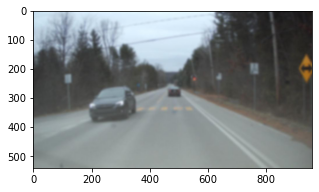

In [32]:
# pick-up randomly any sample
sample_number = 805; #np.random.randint(len(dataset));
data = dataset.__getitem__(sample_number)

image = data[0]
boxes = data[5]
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(image)

## Camera

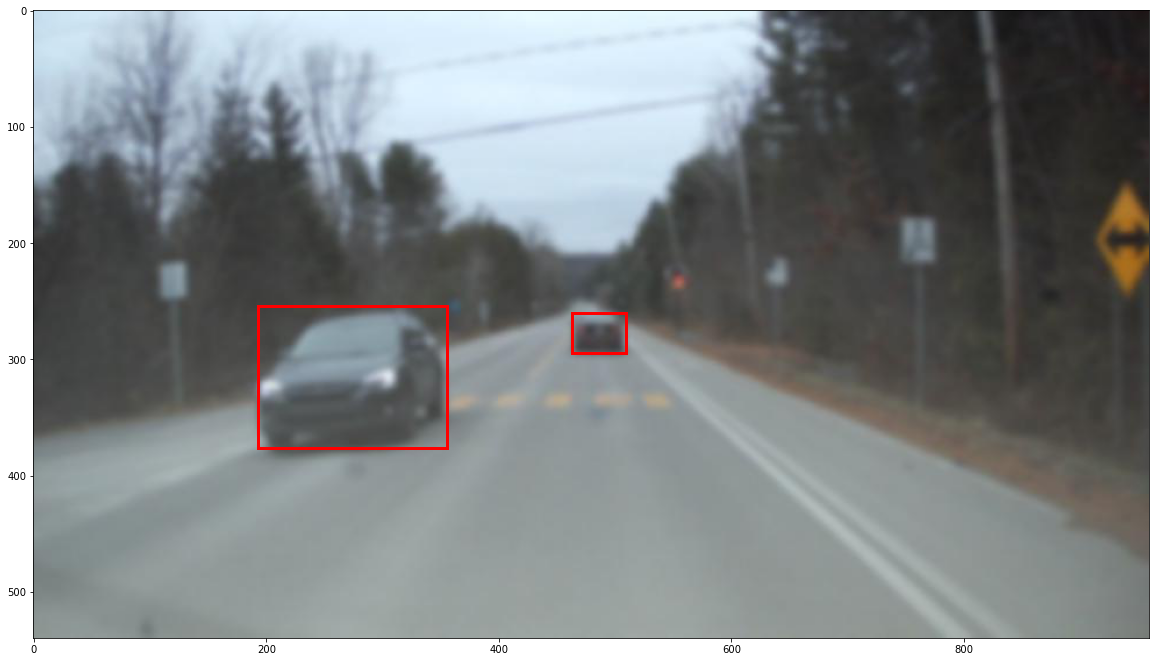

In [33]:
image = data[0]
boxes = data[5]

fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(image)

for box in boxes:
    if(box[0]==-1):
        break # -1 means no object
    rect = Rectangle(box[:2]/2,(box[2]-box[0])/2,(box[3]-box[1])/2,linewidth=3, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
# Note, coordinates are divided by 2 as image were saved in quarter resolution

In [34]:
image_data = data[0]
radarfft_data = data[1]
radar_data = data[2]
lidar_data = data[3]
boxes_data = data[5]

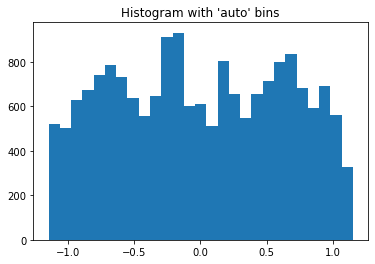

In [35]:
import matplotlib.pyplot as plt

a = lidar_data.copy()
a = a[:,6]
a[a>np.pi] = a[a > np.pi] - np.pi*2
_ = plt.hist(a, bins='auto')  # arguments are passed to np.histogram

plt.title("Histogram with 'auto' bins")
plt.show()

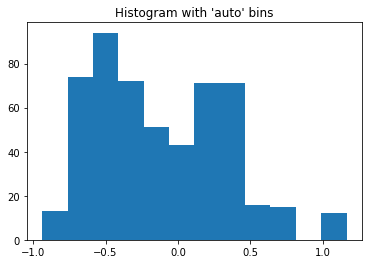

In [36]:
import matplotlib.pyplot as plt

a = radar_data.copy()
#a[a>3] = a[a > 3] - np.pi*2
a = a[:,1]
_ = plt.hist(a, bins='auto')  # arguments are passed to np.histogram

plt.title("Histogram with 'auto' bins")
plt.show()

In [226]:
def ConpensateLayerAngle(pcl,index,sensor_height):
    
    offset=0
    if(index%2==0):
        offset = np.deg2rad(.6)

    x = pcl[:,0] * np.cos(pcl[:,1]+offset) * np.cos(pcl[:,2])
    y = pcl[:,0] * np.cos(pcl[:,1]+offset) * np.sin(pcl[:,2])
    z = pcl[:,0] * np.sin(pcl[:,1]+offset) + sensor_height
    
    pcl[:,0] = x
    pcl[:,1] = y
    pcl[:,2] = z
    
    return pcl

def ProjectDataToImage(lidar_data, image_data, calib, sample_number=0):
    pts = ConpensateLidarLayerAngle(lidar_data.copy(),sample_number,0.42)[:,:3]
    pts[:,[0, 1, 2]] = pts[:,[1, 0, 2]] # Swap the order
    pts[:,0]*=-1 # Left is positive

    imgpts, _ = cv2.projectPoints(np.array(pts), 
                                  calib['extrinsic']['rotation_vector'], 
                                  calib['extrinsic']['translation_vector'],
                                  calib['intrinsic']['camera_matrix'],
                                  calib['intrinsic']['distortion_coefficients'])
    imgpts=imgpts.squeeze(1).astype('int')
    
    (h,w,d) = np.shape(image_data);

    imgpts[:,0] = imgpts[:,0] / (1920 / w)
    imgpts[:,1] = imgpts[:,1] / (1080 / h)

    # Keep only points inside the image size
    idx = np.where( (imgpts[:,0]>=0) & (imgpts[:,0]<image.shape[1]) & (imgpts[:,1]>=0) & (imgpts[:,1]<image.shape[0]))[0]
    return imgpts[idx,0], imgpts[idx,1], idx

def PlotLidarRadarImage(lidar_data, radar_data, image_data, calib, sample_number, ax=plt):
    lx, ly, _ = ProjectDataToImage(lidar_data[:,[4,5,6]], image_data, calib, sample_number)
    l_hdl = ax.scatter(lx,ly,color='b', alpha=.1)

    rx, ry, idx = ProjectDataToImage(radar_data[:,[0,2,1]], image_data, calib)
    C = np.zeros((np.shape(idx)[0],4))
    C[:,0] = 1-((radar_data[idx,4]) % 255)/255.0;
    C[:,3] = 1

    r_hdl = ax.scatter(rx,ry, c=C)

    return l_hdl, r_hdl

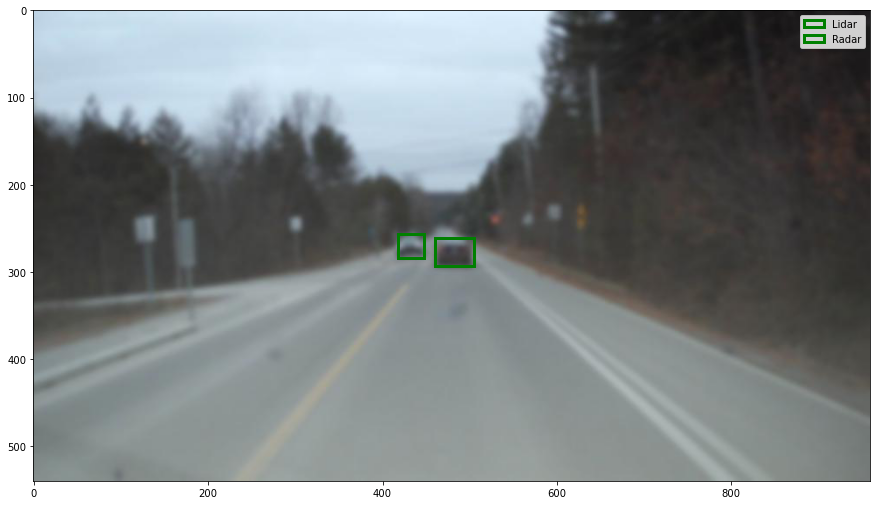

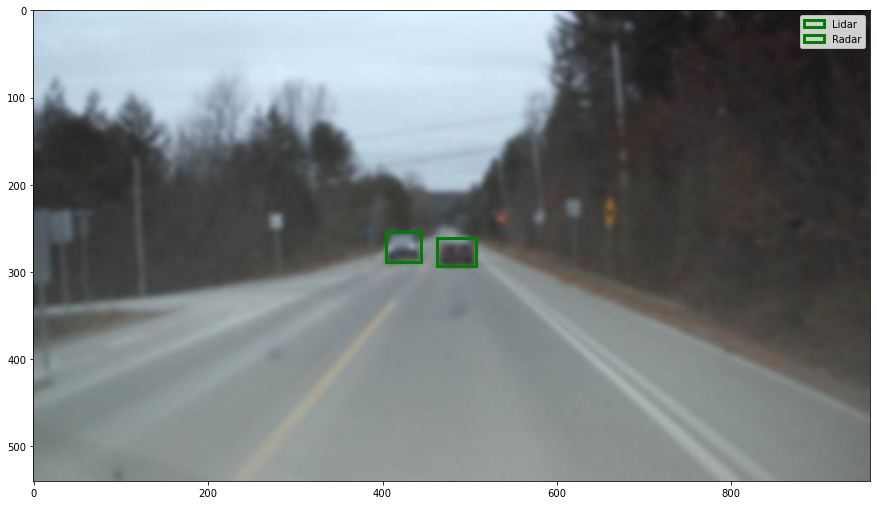

In [235]:
%matplotlib inline
l=dataset.__len__()
print(l)

for sample_number in range(750,850):#dataset.__len__()):
    data = dataset.__getitem__(sample_number)

    image_data = data[0]
    radarfft_data = data[1]
    radar_data = data[2]
    lidar_data = data[3]
    boxes_data = data[5]
    
    fig, ax = plt.subplots(figsize=(15,15))
    ax.imshow(image_data)
    
    #PlotLidarRadarImage(lidar_data, radar_data, image_data, calib, sample_number, ax)
    
    for box in boxes_data:
        if(box[0]==-1):
            break # -1 means no object
        rect = Rectangle(box[:2]/2,(box[2]-box[0])/2,(box[3]-box[1])/2,linewidth=3, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
    
    plt.legend(["Lidar", "Radar", "Labels"])
 
    try:
        pass
        display(plt.gcf())
        clear_output(wait=True)
        plt.pause(0.001)
    except KeyboardInterrupt:
        break
        

# Laser Point Cloud

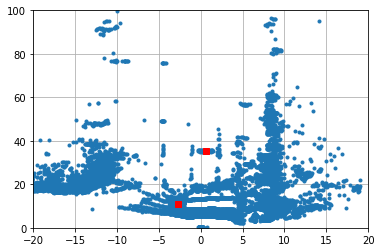

In [11]:
laser_pc = data[3]

plt.plot(-laser_pc[:,1],laser_pc[:,0],'.')
for box in boxes:
    if(box[0]==-1):
        break # -1 means no object
    plt.plot(box[4],box[5],'rs')
plt.xlim(-20,20)
plt.ylim(0,100)
plt.grid()

# Radar Point Cloud

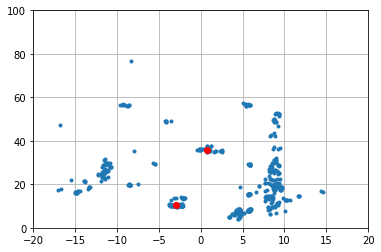

In [12]:
radar_pc = data[2]

plt.plot(-radar_pc[:,6],radar_pc[:,5],'.')
for box in boxes:
    if(box[0]==-1):
        break # -1 means no object
    plt.plot(box[7],box[8],'ro')
plt.xlim(-20,20)
plt.ylim(0,100)
plt.grid()

# Radar FFT spectrums

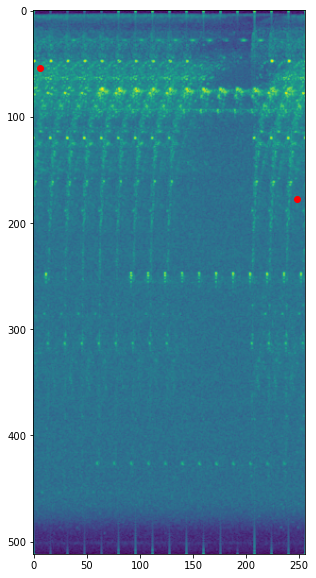

In [13]:
radar_FFT = data[1]
radar_FFT = radar_FFT[...,::2]+1j*radar_FFT[...,1::2]
power_spectrum = np.sum(np.abs(radar_FFT),axis=2)

plt.figure(figsize=(10,10))
plt.imshow(np.log10(power_spectrum))

for box in boxes:
    if(box[0]==-1):
        break # -1 means no object
    Range = box[9] * 512/103 # 512 range bins for 103m
    Azimuth = box[10]
    Doppler = box[11]
    plt.plot(Doppler,Range,'ro')

# Segmentation map

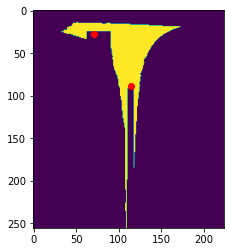

In [14]:
segmap = data[4]
plt.imshow(segmap) # In polar coordinnates
# Range resolution divided by 2
# Azimuth angle crop to 448 and resolution divided by 2
for box in boxes:
    if(box[0]==-1):
        break # -1 means no object
    Range = box[9]*512/103/2
    Azimuth = -box[10]/0.4

    plt.plot(segmap.shape[1]/2+Azimuth ,Range,'ro')

# Pytorch Loader

In [15]:
# Loader split the dataset in Train, Validation, and Test set based on sequences, 
# that is to say samples from a sequence can not be mixed between sets

In [16]:
train_loader, val_loader, test_loader = CreateDataLoaders(dataset)
print('Batch size:',[train_loader.batch_size, val_loader.batch_size,test_loader.batch_size])
print('train_loader:',len(train_loader))
print('val_loader:',len(val_loader))
print('test_loader:',len(test_loader))

Batch size: [4, 4, 4]
train_loader: 1558
val_loader: 247
test_loader: 259
